In [10]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from mne.decoding import Vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, pairwise_distances
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

### Read MEG data and metadata

In [2]:
ROOT = Path.cwd()                     # .../MEG/Data Analysis
MEG_ROOT = ROOT.parent                # .../MEG

LOCALIZER_EPO = (
    MEG_ROOT / "Data" / "Pilot" / "BIDS" / "derivatives" /
    "mne-bids-pipeline" / "sub-01" / "meg" / "sub-01_task-localizer_epo.fif"
)

epochs = mne.read_epochs(LOCALIZER_EPO)

# Read labels
df = pd.read_csv("metadata.csv")
epochs.metadata = df
print(df.head())

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 11 columns
   subject_id       task  trial_block  trial_number stimulus_type meaning  \
0           1  localizer            1             1          word   carre   
1           1  localizer            1             2         image   croix   
2           1  localizer            1             3          word   dinde   
3           1  localizer            1             4         image   biche   
4           1  localizer            1             5          word  cercle   

  meaning_superordinate     stimulus participant_response  reaction_time  \
0                 shape   wo

(470, 102, 51)
(470, 5202)
(8, 5202)


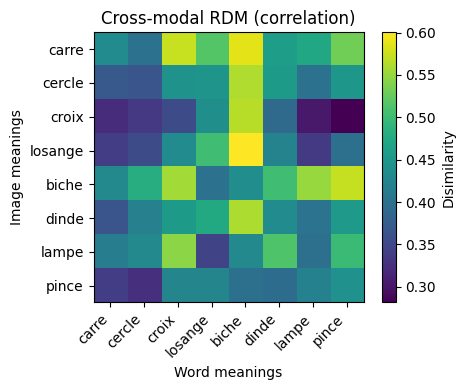

In [3]:
def crossmodal_rdm(epochs, tmin=None, tmax=None, picks=None, 
                   meaning_col="meaning",
                   stim_col="stimulus_type",
                   a_cond="image", b_cond="word",
                   metric="correlation",
                   order=None):
    """
    Build an RDM where rows are meanings in `a_cond` (e.g., image)
    and columns are meanings in `b_cond` (e.g., word).
    Each cell is the dissimilarity between the class-mean patterns.
    """

    # 1) Subset each condition
    A = epochs[f'{stim_col} == "{a_cond}" and participant_correct == True'].copy()
    B = epochs[f'{stim_col} == "{b_cond}" and participant_correct == True'].copy()

    # 2) Optional crop/pick to define the spatiotemporal pattern
    if (tmin is not None) or (tmax is not None):
        A.crop(tmin=tmin, tmax=tmax)
        B.crop(tmin=tmin, tmax=tmax)
    if picks is not None:
        A.pick(picks)
        B.pick(picks)

    # 3) Get data and vectorize (epochs × features)
    XA = A.get_data().reshape(len(A), -1)
    XB = B.get_data().reshape(len(B), -1)
    print(A.get_data().shape)
    print(XA.shape)

    # 4) Meanings present in BOTH modalities, keep consistent order
    meanings_A = A.metadata[meaning_col].astype(str).values
    meanings_B = B.metadata[meaning_col].astype(str).values
    shared_meanings = sorted(set(meanings_A).intersection(set(meanings_B)))

    if not order:
        shared_meanings = sorted(set(meanings_A).intersection(set(meanings_B)))
    else:
        # Keep only the ones actually present in both conditions
        shared_meanings = [m for m in order
                           if (m in meanings_A) and (m in meanings_B)]

    # 6) Average to class patterns per meaning
    def class_means(X, labels, classes):
        out = []
        for c in classes:
            out.append(X[labels == c].mean(axis=0))
        return np.vstack(out)

    patterns_A = class_means(XA, meanings_A, shared_meanings)  # rows
    patterns_B = class_means(XB, meanings_B, shared_meanings)  # cols

    print(patterns_A.shape)

    # 7) Cross-condition dissimilarities (rows=images, cols=words)
    RDM = pairwise_distances(patterns_A, patterns_B, metric=metric)
    SIM = 1 - RDM

    return RDM, shared_meanings

# ---- Use it ----
RDM, labels = crossmodal_rdm(
    epochs,
    tmin=0.2, tmax=0.4,
    picks="mag",
    meaning_col="meaning",
    stim_col="stimulus_type",
    a_cond="image", b_cond="word",
    metric="cosine",
    order=['carre', 'cercle', 'croix', 'losange', 'biche', 'dinde', 'lampe', 'pince']    # try "cosine" or "euclidean" too
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(RDM, interpolation="nearest")
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
ax.set_xlabel("Word meanings"); ax.set_ylabel("Image meanings")
ax.set_title("Cross-modal RDM (correlation)")
fig.colorbar(im, ax=ax, label="Disimilarity")
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from ipywidgets import FloatSlider, Dropdown, Checkbox, VBox, HBox
from IPython.display import display
import matplotlib.patches as patches
import matplotlib.patheffects as pe

def crossmodal_rdm_widget(epochs, 
                          picks="mag",
                          meaning_col="meaning",
                          stim_col="stimulus_type",
                          correct_col="participant_correct",
                          a_cond="image", b_cond="word",
                          metric="correlation",
                          order=None,
                          time_min=-0.2, time_max=1.0,
                          default_time=0.200,
                          window=0.040,
                          show_similarity=False):

    # --- subset and data ---
    A = epochs[f'{stim_col} == "{a_cond}" and {correct_col} == True'].copy()
    B = epochs[f'{stim_col} == "{b_cond}" and {correct_col} == True'].copy()
    if picks is not None:
        A.pick(picks)
        B.pick(picks)

    data_A = A.get_data()
    data_B = B.get_data()
    times  = A.times

    meanings_A = A.metadata[meaning_col].astype(str).values
    meanings_B = B.metadata[meaning_col].astype(str).values

    if order is None:
        shared = sorted(set(meanings_A).intersection(set(meanings_B)))
    else:
        shared = [m for m in order if (m in meanings_A) and (m in meanings_B)]
    if len(shared) == 0:
        raise ValueError("No shared meanings between modalities with the provided 'order'.")

    # --- helpers ---
    def slice_time_idx(t0, width):
        lo, hi = t0 - width/2, t0 + width/2
        idx = np.where((times >= lo) & (times <= hi))[0]
        if idx.size == 0:
            idx = np.array([np.argmin(np.abs(times - t0))])
        return idx

    def class_means(X3d, labels, classes, tidx):
        X2d = X3d[:, :, tidx].reshape(len(X3d), -1)
        return np.vstack([X2d[labels == c].mean(axis=0) for c in classes])

    # --- figure created once ---
    fig, ax = plt.subplots(figsize=(5.2, 4.4), constrained_layout=True)

    # make placeholders, but DO NOT display yet
    M0 = np.zeros((len(shared), len(shared)))
    im = ax.imshow(M0, interpolation="nearest")
    cbar = fig.colorbar(im, ax=ax)

    # Draw 1×1 boxes centered on each diagonal cell
    diag_boxes = []
    for i in range(len(shared)):
        r = patches.Rectangle((i - 0.5, i - 0.5), 1, 1,
                            fill=False, edgecolor='k', linewidth=1)
        # optional: white halo so the edge is visible on dark/light colors
        #r.set_path_effects([pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])
        ax.add_patch(r)
        diag_boxes.append(r)

    ax.set_xticks(range(len(shared))); ax.set_xticklabels(shared, rotation=45, ha="right")
    ax.set_yticks(range(len(shared))); ax.set_yticklabels(shared)
    ax.set_xlabel(f"{b_cond.upper()} meanings"); ax.set_ylabel(f"{a_cond.upper()} meanings")

    # --- widgets ---
    step = float(np.diff(times).mean())
    t_slider = FloatSlider(description="Time (s)", min=time_min, max=time_max,
                           step=step, value=float(default_time),
                           readout_format=".3f", continuous_update=False)
    win_slider = FloatSlider(description="Window (s)", min=0.0, max=0.200,
                             step=0.010, value=window, readout_format=".3f")
    metric_dd  = Dropdown(description="Metric",
                          options=["correlation","cosine","euclidean","cityblock"],
                          value=metric)
    sim_chk    = Checkbox(description="Show similarity (1 - D)",
                          value=show_similarity)

    # --- update routine ---
    def update(*_):
        t0   = float(t_slider.value)
        w    = float(win_slider.value)
        metr = metric_dd.value
        show_sim = sim_chk.value

        tidx = slice_time_idx(t0, w)
        PA = class_means(data_A, meanings_A, shared, tidx)
        PB = class_means(data_B, meanings_B, shared, tidx)

        RDM = pairwise_distances(PA, PB, metric=metr)
        M   = (1 - RDM) if (show_sim and metr in ("correlation","cosine")) else RDM

        # update image & colorbar in place
        im.set_data(M)
        im.set_clim(vmin=np.nanmin(M), vmax=np.nanmax(M))
        cbar.update_normal(im)

        title_core = "SIM (1 - D)" if (show_sim and metr in ("correlation","cosine")) else "RDM (distance)"
        ax.set_title(f"Cross-modal {title_core} @ {t0:.3f}s \n (window={w:.3f}s, metric={metr})")

        fig.canvas.draw_idle()

    # hook updates
    for w in (t_slider, win_slider, metric_dd, sim_chk):
        w.observe(update, names="value")

    # initial draw
    ui = VBox([HBox([t_slider, win_slider]), HBox([metric_dd, sim_chk])])
    display(ui)
    update()

    return dict(fig=fig, ax=ax, image=im, cbar=cbar,
                time_slider=t_slider, window_slider=win_slider,
                metric_dropdown=metric_dd, similarity_checkbox=sim_chk)

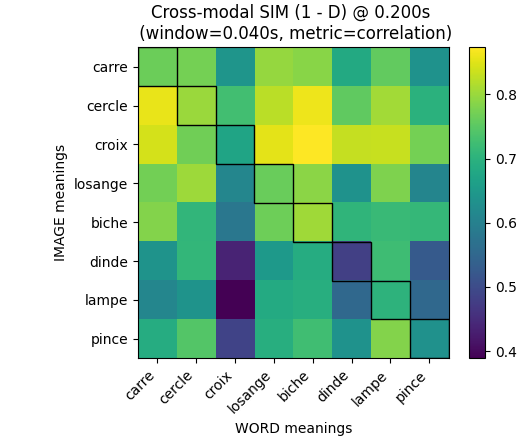

In [11]:
_ = crossmodal_rdm_widget(
    epochs,
    picks="mag",
    meaning_col="meaning",
    stim_col="stimulus_type",
    a_cond="image", b_cond="word",
    metric="correlation",
    order=['carre','cercle','croix','losange','biche','dinde','lampe','pince'],
    time_min=-0.2, time_max=1.0,     # your epoch range
    default_time=0.200,              # starting time
    window=0.040,                    # ±20 ms around the timepoint
    show_similarity=True             # start in similarity mode
)